In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, cm
from loadmodules import *
import matplotlib.ticker as ticker

In [9]:
%matplotlib inline

In [12]:
simulation_list = [directory for directory in os.listdir('.') if 'Au6_lvl5_f' in directory]
print(simulation_list)

['Au6_lvl5_f9742_icmftest', 'Au6_lvl5_f9742_evtest_bhoff', 'Au6_lvl5_f9742_noconstrain', 'Au6_lvl5_f9742_evtest_bhon']


In [13]:
cluster_formation_rate = []
age_distribution_surviving = []

nbins = 40
min_range = 0
max_range = 14
for sim in simulation_list[2:]:
    sf = load_subfind(127, dir=sim+'/output/')
    s = gadget_readsnap(127, snappath=sim+'/output/', subfind=sf, applytransformationfacs=True, hdf5=True, loadonlyhalo=0, loadonlytype=[4])

    s.calc_sf_indizes(sf)
    rot_matrix = s.select_halo(sf)

    s.data['pos'] *= 1e3 # in kpc
    s.data['mass'] *= 1e10 # change mass to solar masses
    s.data['mclt'] *= 1e10  
    s.data['imcl'] *= 1e10

    s.data['r'] = np.sqrt(np.sum((s.data['pos'])**2, axis=1))

    mask_clusters_initial = (s.data['incl'] > 0 )

    cluster_masses = s.data['mclt'][mask_clusters_initial].flatten()
    init_cluster_masses = s.data['imcl'][mask_clusters_initial].flatten()

    not_empty_clusters = (init_cluster_masses>0)

    cluster_masses = cluster_masses[not_empty_clusters]
    init_cluster_masses = init_cluster_masses[not_empty_clusters]

    print('Simulation: {:s}'.format(sim))
    print('Total number of formed clusters {:d}'.format(s.data['incl'].sum()))
    print('Total number of surviving clusters {:d}'.format(s.data['nclt'].sum()))
    print('Maximum initial number of clusters per star {:d}'.format(s.data['incl'].max()))
    print('Maximum initial mass {:2.2e} Msun'.format(init_cluster_masses.max()))
    print('Maximum present-day mass {:2.2e} Msun'.format(cluster_masses.max()))

    disruption_time = s.data['drpt'][mask_clusters_initial].flatten()
    disruption_time = disruption_time[not_empty_clusters]

    clusters_formtime = np.repeat(s.data['age'][mask_clusters_initial], s.data['incl'][mask_clusters_initial])
    clusters_age = s.cosmology_get_lookback_time_from_a(clusters_formtime, is_flat=True)

    print('Number of disrupted clusters {:d}'.format((disruption_time>0).sum()))

    mask_problematic = s.data['imfc']>1
    print('Problematic stars with clusters {:4d}'.format(mask_problematic.sum()))
    print('That`s {:.3f}% of stars with clusters'.format(mask_problematic.sum()/mask_clusters_initial.sum() * 100))

    dist, bins = np.histogram(clusters_age, bins=nbins, range=[min_range,max_range], weights=init_cluster_masses/((max_range-min_range)/nbins) /1e9)
    cluster_formation_rate.append(dist)
    dist, bins = np.histogram(clusters_age[cluster_masses>0.], bins=nbins, range=[min_range, max_range], density=True)
    age_distribution_surviving.append(dist)

/home/pdcg/pylib/gadget_subfind.py:447: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('int64'):
/home/pdcg/pylib/gadget_snap.py:730: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.01912507861852646
Found 70258 stars.
Simulation: Au6_lvl5_f9742_noconstrain
Total number of formed clusters 134313
Total number of surviving clusters 52002
Maximum initial number of clusters per star 12
Maximum initial mass 7.50e+07 Msun
Maximum present-day mass 4.54e+07 Msun
Number of disrupted clusters 82311
Problematic stars with clusters  721
That`s 1.057% of stars with clusters
galrad= 0.018873251974582672
Found 71746 stars.
Simulation: Au6_lvl5_f9742_evtest_bhon
Total number of formed clusters 34397
Total number of surviving clusters 8409
Maximum initial number of clusters per star 13
Maximum initial mass 6.11e+07 Msun
Maximum present-day mass 3.44e+07 Msun
Number of disrupted clusters 25988
Problematic stars with clusters  248
That`s 1.679% of stars with clusters


In [14]:
def get_redshift(lookbacktime):
    a_test = np.linspace(1e-2,1,500)
    a_analogous = []
    for t in lookbacktime:
        a_analogous.append(a_test[np.absolute(s.cosmology_get_lookback_time_from_a(a_test, is_flat=True) - t).argmin()])
    a_analogous = np.array(a_analogous)
    return 1/a_analogous - 1

/tmp/ipykernel_1440511/3304134392.py:18: RuntimeWarning: invalid value encountered in divide
  ax[1].step(bins[:-1], cluster_formation_rate[1]/cluster_formation_rate[0], where='post', c='g', label=r'$\lambda_i < -10$ Gyr$^{-2}$')


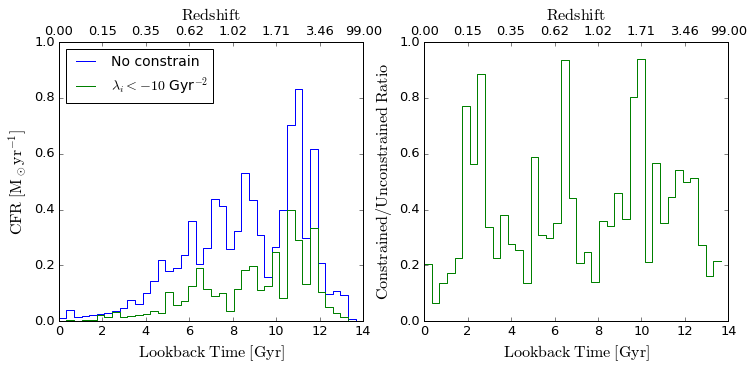

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].step(bins[:-1], cluster_formation_rate[0], where='post', label='No constrain')
ax[0].step(bins[:-1], cluster_formation_rate[1], where='post', c='g', label=r'$\lambda_i < -10$ Gyr$^{-2}$')
ax[0].set_ylabel(r'$\rm{CFR \; [M_\odot yr^{-1}]}$', fontsize=16)
ax[0].set_xlabel(r'$\rm{Lookback \; Time \; [Gyr]}$', fontsize=16)
ax[0].legend(fontsize=14, loc='upper left')
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[0].set_ylim(0, 1.)
sax = ax[0].twiny()
time_ticks = ax[0].get_xticks()
sax.set_xlim(ax[0].get_xlim())
sax.set_xticks(time_ticks)
sax.set_xticklabels(['{:.2f}'.format(z) for z in get_redshift(time_ticks)])
sax.set_xlabel(r'$\rm Redshift$', fontsize=16)
sax.tick_params(axis='both', which='major', labelsize=13)

ax[1].step(bins[:-1], cluster_formation_rate[1]/cluster_formation_rate[0], where='post', c='g', label=r'$\lambda_i < -10$ Gyr$^{-2}$')
ax[1].hlines(1, 0, 14, linestyle='--', color='black')
sax = ax[1].twiny()
time_ticks = ax[1].get_xticks()
sax.set_xlim(ax[1].get_xlim())
sax.set_xticks(time_ticks)
sax.set_xticklabels(['{:.2f}'.format(z) for z in get_redshift(time_ticks)])
sax.set_xlabel(r'$\rm Redshift$', fontsize=16)
sax.tick_params(axis='both', which='major', labelsize=13)
ax[1].set_ylabel(r'$\rm{Constrained/Unconstrained \; Ratio}$', fontsize=16)
ax[1].set_xlabel(r'$\rm{Lookback \; Time \; [Gyr]}$', fontsize=16)
# ax[1].legend(fontsize=14, loc='upper right')
ax[1].tick_params(axis='both', which='major', labelsize=13)
# plt.savefig('plots/cluster_formation_rate_ratio_aa96_cfefit.pdf')

/tmp/ipykernel_1440511/3304134392.py:18: RuntimeWarning: invalid value encountered in divide
  ax[1].step(bins[:-1], cluster_formation_rate[1]/cluster_formation_rate[0], where='post', c='g', label=r'$\lambda_i < -10$ Gyr$^{-2}$')


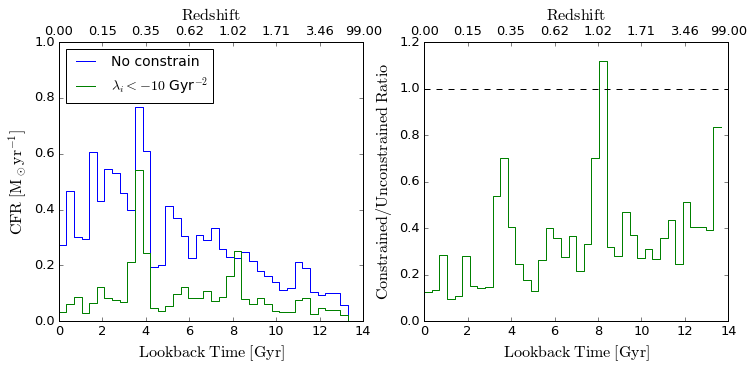

In [15]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].step(bins[:-1], cluster_formation_rate[0], where='post', label='No constrain')
ax[0].step(bins[:-1], cluster_formation_rate[1], where='post', c='g', label=r'$\lambda_i < -10$ Gyr$^{-2}$')
ax[0].set_ylabel(r'$\rm{CFR \; [M_\odot yr^{-1}]}$', fontsize=16)
ax[0].set_xlabel(r'$\rm{Lookback \; Time \; [Gyr]}$', fontsize=16)
ax[0].legend(fontsize=14, loc='upper left')
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[0].set_ylim(0, 1.)
sax = ax[0].twiny()
time_ticks = ax[0].get_xticks()
sax.set_xlim(ax[0].get_xlim())
sax.set_xticks(time_ticks)
sax.set_xticklabels(['{:.2f}'.format(z) for z in get_redshift(time_ticks)])
sax.set_xlabel(r'$\rm Redshift$', fontsize=16)
sax.tick_params(axis='both', which='major', labelsize=13)

ax[1].step(bins[:-1], cluster_formation_rate[1]/cluster_formation_rate[0], where='post', c='g', label=r'$\lambda_i < -10$ Gyr$^{-2}$')
ax[1].hlines(1, 0, 14, linestyle='--', color='black')
sax = ax[1].twiny()
time_ticks = ax[1].get_xticks()
sax.set_xlim(ax[1].get_xlim())
sax.set_xticks(time_ticks)
sax.set_xticklabels(['{:.2f}'.format(z) for z in get_redshift(time_ticks)])
sax.set_xlabel(r'$\rm Redshift$', fontsize=16)
sax.tick_params(axis='both', which='major', labelsize=13)
ax[1].set_ylabel(r'$\rm{Constrained/Unconstrained \; Ratio}$', fontsize=16)
ax[1].set_xlabel(r'$\rm{Lookback \; Time \; [Gyr]}$', fontsize=16)
# ax[1].legend(fontsize=14, loc='upper right')
ax[1].tick_params(axis='both', which='major', labelsize=13)
# plt.savefig('plots/cluster_formation_rate_ratio_aa96_cfefit.pdf')

/tmp/ipykernel_1440511/2398750389.py:18: RuntimeWarning: invalid value encountered in divide
  ax[1].step(bins[:-1], age_distribution_surviving[1]/age_distribution_surviving[0], where='post', c='g', label=r'$\lambda_i < -10$ Gyr$^{-2}$')


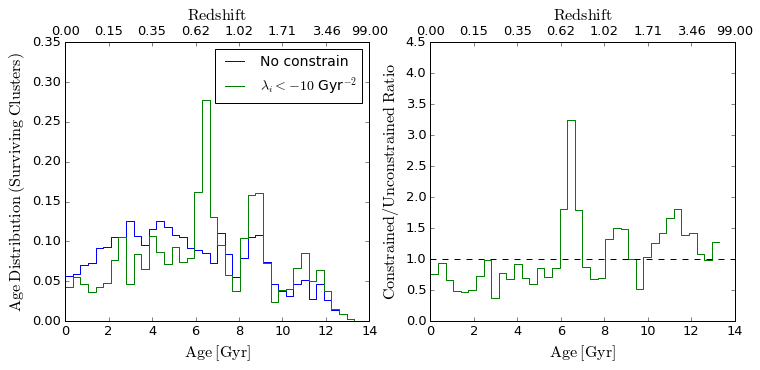

In [11]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].step(bins[:-1], age_distribution_surviving[0], where='post', label='No constrain')
ax[0].step(bins[:-1], age_distribution_surviving[1], where='post', c='g', label=r'$\lambda_i < -10$ Gyr$^{-2}$')
ax[0].set_ylabel(r'$\rm{Age \; Distribution \; (Surviving \;Clusters)}$', fontsize=16)
ax[0].set_xlabel(r'$\rm{Age \; [Gyr]}$', fontsize=16)
ax[0].legend(fontsize=14, loc='upper right')
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[0].set_ylim(0, 0.35)
sax = ax[0].twiny()
time_ticks = ax[0].get_xticks()
sax.set_xlim(ax[0].get_xlim())
sax.set_xticks(time_ticks)
sax.set_xticklabels(['{:.2f}'.format(z) for z in get_redshift(time_ticks)])
sax.set_xlabel(r'$\rm Redshift$', fontsize=16)
sax.tick_params(axis='both', which='major', labelsize=13)

ax[1].step(bins[:-1], age_distribution_surviving[1]/age_distribution_surviving[0], where='post', c='g', label=r'$\lambda_i < -10$ Gyr$^{-2}$')
ax[1].hlines(1, 0, 14, linestyle='--', color='black')
ax[1].set_ylim(0, 4.5)
sax = ax[1].twiny()
time_ticks = ax[1].get_xticks()
sax.set_xlim(ax[1].get_xlim())
sax.set_xticks(time_ticks)
sax.set_xticklabels(['{:.2f}'.format(z) for z in get_redshift(time_ticks)])
sax.set_xlabel(r'$\rm Redshift$', fontsize=16)
sax.tick_params(axis='both', which='major', labelsize=13)
# ax[1].legend(fontsize=14, loc='upper right')
ax[1].set_ylabel(r'$\rm{Constrained/Unconstrained \; Ratio}$', fontsize=16)
ax[1].set_xlabel(r'$\rm{Age \; [Gyr]}$', fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=13)
# plt.savefig('plots/age_distribution_ratio_aa96_cfefit.pdf')

/tmp/ipykernel_1440511/2398750389.py:18: RuntimeWarning: invalid value encountered in divide
  ax[1].step(bins[:-1], age_distribution_surviving[1]/age_distribution_surviving[0], where='post', c='g', label=r'$\lambda_i < -10$ Gyr$^{-2}$')


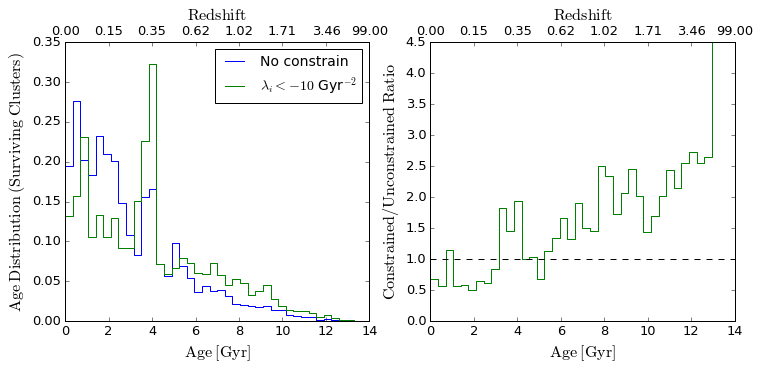

In [16]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].step(bins[:-1], age_distribution_surviving[0], where='post', label='No constrain')
ax[0].step(bins[:-1], age_distribution_surviving[1], where='post', c='g', label=r'$\lambda_i < -10$ Gyr$^{-2}$')
ax[0].set_ylabel(r'$\rm{Age \; Distribution \; (Surviving \;Clusters)}$', fontsize=16)
ax[0].set_xlabel(r'$\rm{Age \; [Gyr]}$', fontsize=16)
ax[0].legend(fontsize=14, loc='upper right')
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[0].set_ylim(0, 0.35)
sax = ax[0].twiny()
time_ticks = ax[0].get_xticks()
sax.set_xlim(ax[0].get_xlim())
sax.set_xticks(time_ticks)
sax.set_xticklabels(['{:.2f}'.format(z) for z in get_redshift(time_ticks)])
sax.set_xlabel(r'$\rm Redshift$', fontsize=16)
sax.tick_params(axis='both', which='major', labelsize=13)

ax[1].step(bins[:-1], age_distribution_surviving[1]/age_distribution_surviving[0], where='post', c='g', label=r'$\lambda_i < -10$ Gyr$^{-2}$')
ax[1].hlines(1, 0, 14, linestyle='--', color='black')
ax[1].set_ylim(0, 4.5)
sax = ax[1].twiny()
time_ticks = ax[1].get_xticks()
sax.set_xlim(ax[1].get_xlim())
sax.set_xticks(time_ticks)
sax.set_xticklabels(['{:.2f}'.format(z) for z in get_redshift(time_ticks)])
sax.set_xlabel(r'$\rm Redshift$', fontsize=16)
sax.tick_params(axis='both', which='major', labelsize=13)
# ax[1].legend(fontsize=14, loc='upper right')
ax[1].set_ylabel(r'$\rm{Constrained/Unconstrained \; Ratio}$', fontsize=16)
ax[1].set_xlabel(r'$\rm{Age \; [Gyr]}$', fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=13)
# plt.savefig('plots/age_distribution_ratio_aa96_cfefit.pdf')

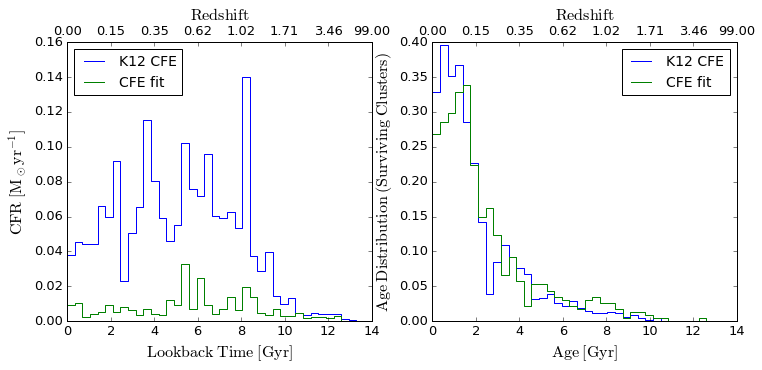

In [7]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].step(bins[:-1], cluster_formation_rate[0], where='post', label='K12 CFE')
ax[0].step(bins[:-1], cluster_formation_rate[1], where='post', c='g', label='CFE fit')
ax[0].set_ylabel(r'$\rm{CFR \; [M_\odot yr^{-1}]}$', fontsize=16)
ax[0].set_xlabel(r'$\rm{Lookback \; Time \; [Gyr]}$', fontsize=16)
ax[0].legend(fontsize=14, loc='upper left')
ax[0].tick_params(axis='both', which='major', labelsize=13)
# ax[0].set_ylim(0, 1.)
sax = ax[0].twiny()
time_ticks = ax[0].get_xticks()
sax.set_xlim(ax[0].get_xlim())
sax.set_xticks(time_ticks)
sax.set_xticklabels(['{:.2f}'.format(z) for z in get_redshift(time_ticks)])
sax.set_xlabel(r'$\rm Redshift$', fontsize=16)
sax.tick_params(axis='both', which='major', labelsize=13)

ax[1].step(bins[:-1], age_distribution_surviving[0], where='post', label='K12 CFE')
ax[1].step(bins[:-1], age_distribution_surviving[1], where='post', c='g', label='CFE fit')
ax[1].set_ylabel(r'$\rm{Age \; Distribution \; (Surviving \;Clusters)}$', fontsize=16)
ax[1].set_xlabel(r'$\rm{Age \; [Gyr]}$', fontsize=16)
ax[1].legend(fontsize=14, loc='upper right')
ax[1].tick_params(axis='both', which='major', labelsize=13)
# ax[1].set_ylim(0, 0.35)
sax = ax[1].twiny()
time_ticks = ax[1].get_xticks()
sax.set_xlim(ax[1].get_xlim())
sax.set_xticks(time_ticks)
sax.set_xticklabels(['{:.2f}'.format(z) for z in get_redshift(time_ticks)])
sax.set_xlabel(r'$\rm Redshift$', fontsize=16)
sax.tick_params(axis='both', which='major', labelsize=13)